# This is a fork of:

  Github->https://github.com/LukeDitria/pytorch_tutorials/blob/main/section7_autoencoders/solutions/Pytorch2_Variational_Autoencoders_Solutions.ipynb

  YouTube->https://www.youtube.com/watch?v=dDJv6DiuqEk&list=PLN8j_qfCJpNhhY26TQpXC5VeK-_q3YLPa&index=16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

In [2]:
batchSize = 64
lr = 1e-4

# Number of Training epochs
nepoch = 10

# The size of the Latent Vector
latent_size = 128
root = "../../datasets"

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

# Create an MNIST dataset and dataloader

In [4]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])

train_set = Datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batchSize,shuffle=True, num_workers=2)

test_set = Datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batchSize, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:01<00:00, 14063720.08it/s]


Extracting ../../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210727.25it/s]


Extracting ../../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3929591.43it/s]


Extracting ../../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11896571.35it/s]

Extracting ../../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/FashionMNIST/raw



In [5]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)

    # Here is our KL divergance loss implemented in code
    # We will use the mean across the dimensions instead of the sum (which is common and would require different scaling)
    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

    # We'll tune the "strength" of KL divergance loss to get a good result
    loss = recon_loss + 0.1 * kl_loss
    return loss

# VAE Network

In [6]:
# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_out)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x_skip = self.conv3(x)

        x = F.elu(self.bn1(self.conv1(x)))
        x = self.conv2(x) + x_skip

        return F.elu(self.bn2(x))


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = F.elu(self.bn2(x_in))

        x_skip = self.up_nn(self.conv3(x))

        x = self.up_nn(F.elu(self.bn2(self.conv1(x))))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch)
        self.conv_block2 = DownBlock(ch, ch * 2)
        self.conv_block3 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.conv_mu = nn.Conv2d(4 * ch, z, 4, 1)
        self.conv_logvar = nn.Conv2d(4 * ch, z, 4, 1)

    # This function will sample from our distribution
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = F.elu(self.conv_1(x))

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        x = self.sample(mu, logvar)

        return x, mu, logvar


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, z = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_block3 = UpBlock(ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = F.elu(self.conv_block3(x))

        return torch.tanh(self.conv_out(x))

In [7]:
class VAE(nn.Module):
    def __init__(self, channel_in, ch=16, z=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
        self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, logvar = self.encoder(x)

        # Only sample during training or when we want to generate new images
        # just use mu otherwise
        if self.training:
            x = self.decoder(encoding)
        else:
            x = self.decoder(mu)

        return x, mu, logvar

# Visualize our data

In [8]:
# Get a test image
dataiter = iter(test_loader)
test_images, y = next(iter(dataiter))

# View the shape
test_images.shape

torch.Size([64, 1, 32, 32])

In [9]:
y.shape

torch.Size([64])

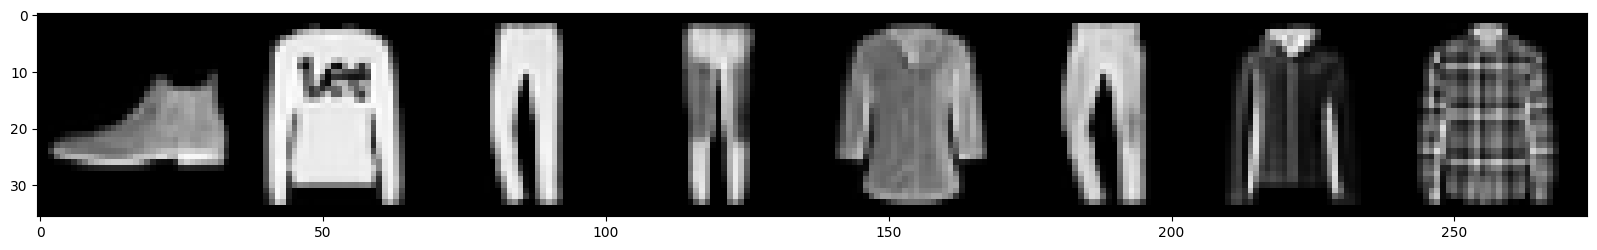

In [10]:
# Visualize the data!!!
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

# Create Network and Optimizer

In [11]:
# Create our network
vae_net = VAE(channel_in=1, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))

# Create loss logger
loss_log = []
train_loss = 0

# Network output

In [12]:
# Pass through a test image to make sure everything is working
recon_data, mu, logvar = vae_net(test_images.to(device))

# View the Latent vector shape
mu.shape

torch.Size([64, 128, 1, 1])

# Start training!

In [13]:
pbar = trange(0, nepoch, leave=False, desc="Epoch")
vae_net.train()
train_loss = 0
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)

        # Forward pass the image in the data tuple
        recon_data, mu, logvar = vae_net(image)

        # Calculate the loss
        loss = vae_loss(recon_data, image, mu, logvar)

        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()

        # Take a training step
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

# Results!

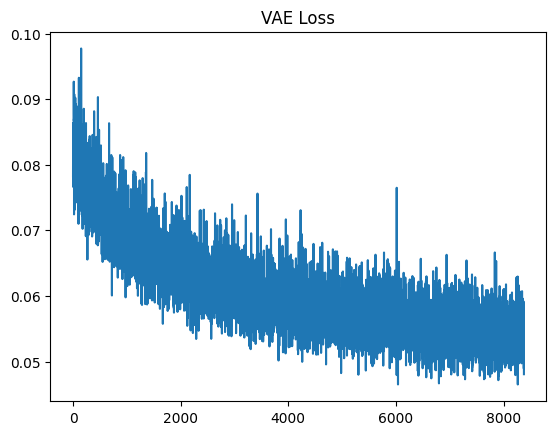

In [23]:
_ = plt.plot(loss_log[1000:])
_ = plt.title("VAE Loss")

In [24]:
vae_net.eval()
recon_data, mu, logvar = vae_net(test_images.to(device))

Ground Truth

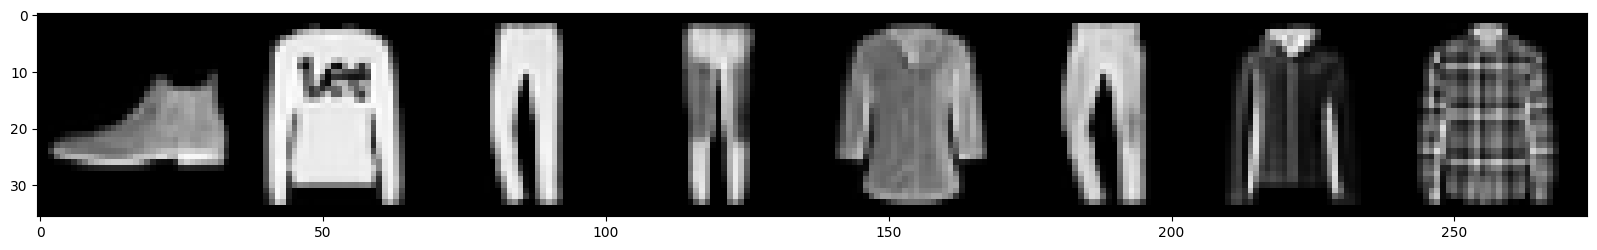

In [25]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Reconstruction

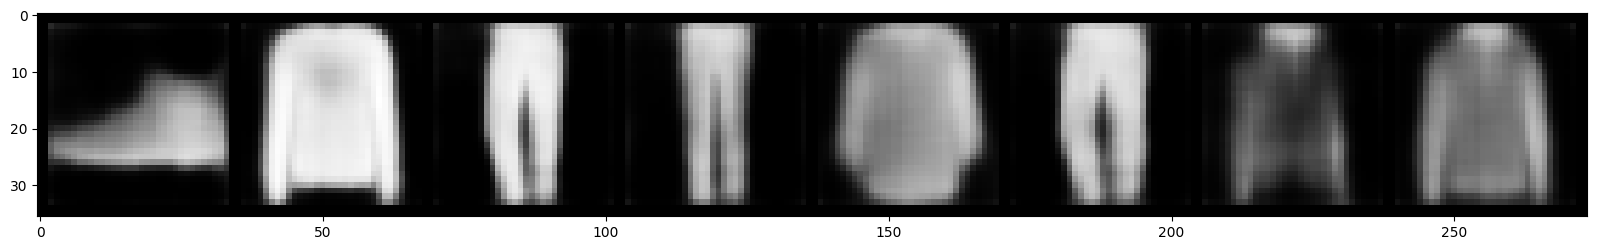

In [26]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Random Permutations

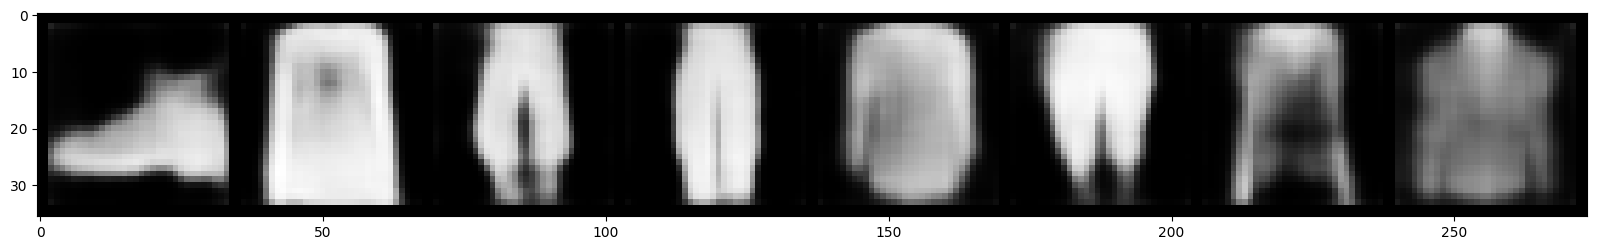

In [27]:
rand_samp = vae_net.decoder(mu + 1 * torch.randn_like(mu))
plt.figure(figsize = (20,10))
out = vutils.make_grid(rand_samp.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

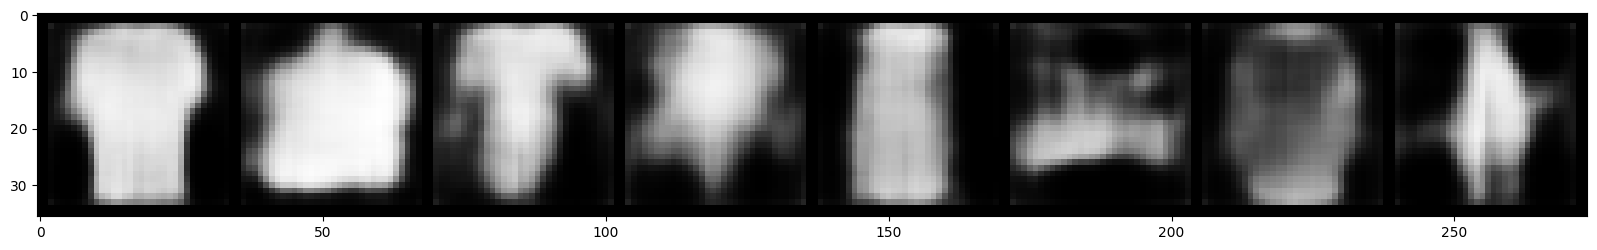

In [28]:
rand_samp = vae_net.decoder(torch.randn_like(mu))
plt.figure(figsize = (20,10))
out = vutils.make_grid(rand_samp.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

# Interpolation in Latent Space

In [29]:
# Initialise the class means to 0
class_means = torch.zeros(10, latent_size)

vae_net.eval()
# Loop through all the data in the validation set
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        recon_data, mu, _ = vae_net(images.to(device))

        # For each batch sum up the latent vectors of the same class
        # (Use a matrix of one hot coded vectors to make it easy)
        class_matrix = F.one_hot(labels, 10).t().type(torch.FloatTensor)
        class_means += torch.matmul(class_matrix, mu.squeeze().detach().cpu())

# In the validation set each class has 1000 images so to find the mean vectors we divide by 1000
class_means /= 1000

Recondstruct the means using the decoder

In [30]:
# Reshape the mean classes to the appropriate shape
class_means = class_means.view(10, latent_size, 1, 1)

# We only need to pass the latent vectors through our decoder
recon_means = vae_net.decoder(class_means.to(device))

Plot out our class means!

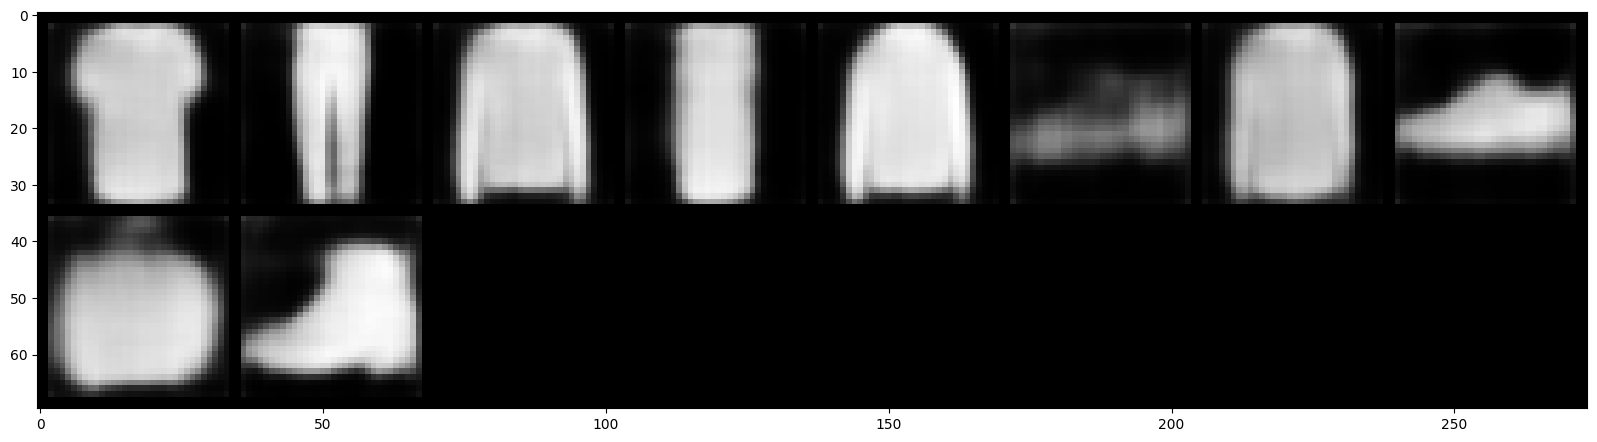

In [31]:
plt.figure(figsize = (20, 10))
out = vutils.make_grid(recon_means.detach().cpu(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Interpolate between two class means

In [32]:
# Pick the two classes to move between
start_class = 4
end_class = 7

# Number of interpolation steps
num_steps = 100
steps = torch.linspace(0,1,num_steps)

# Get the vector pointing from one class to the other
diff_vector = class_means[end_class] - class_means[start_class]

Take "num_steps" from the "start_class" to the "end_class" along the "diff_vector"

In [33]:
latent_steps = class_means[start_class] + (steps.view(num_steps, 1, 1, 1) * diff_vector.view(1, latent_size, 1, 1))
recon_steps = vae_net.decoder(latent_steps.to(device))

Visulise the interpolation

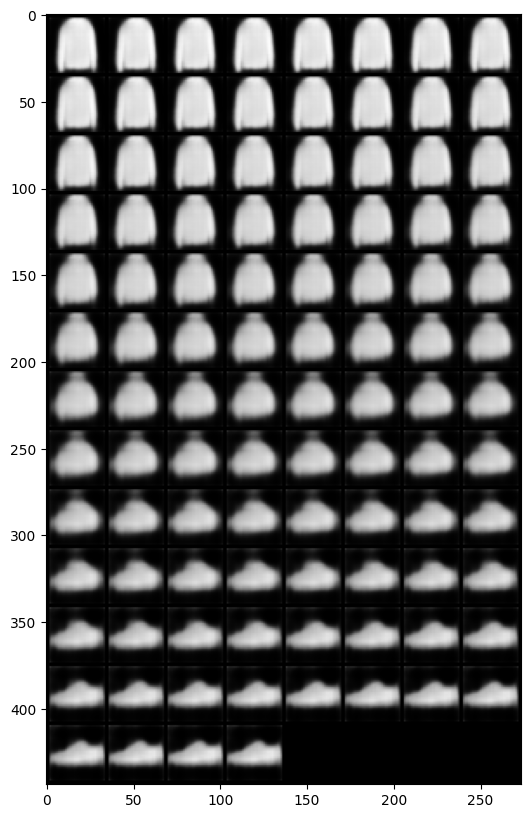

In [34]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_steps.detach().cpu(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

Animate!

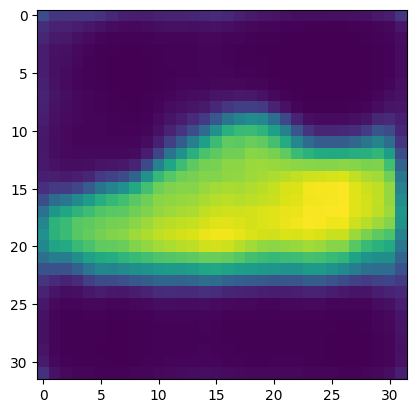

In [35]:
for i in range(num_steps):
    plt.imshow(((recon_steps[i, 0] + 1) / 2).detach().cpu())
    plt.pause(0.01)
    clear_output(True)